In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
data = np.loadtxt(open('../00-Dataset/mnist_train_small.csv', 'rb'), delimiter=',')

In [3]:
data.shape
labels = data[:,0]
data = data[:,1:]


In [4]:
# normalize the data to a range of [0, 1]
dataNorm = data/np.max(data)

In [5]:
dataNorm.shape

(20000, 784)

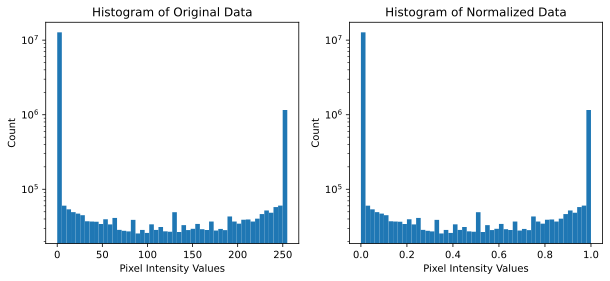

In [6]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel Intensity Values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of Original Data')
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel Intensity Values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Normalized Data')
ax[1].set_yscale('log')
plt.show()

In [7]:
# convert data to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64

train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, train_size = 0.9)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batchSize = 32
train_loader = DataLoader(train_data, batch_size=batchSize, drop_last=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.__len__())


In [8]:
%whos

Variable            Type             Data/Info
----------------------------------------------
DataLoader          type             <class 'torch.utils.data.dataloader.DataLoader'>
F                   module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset       type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                  ndarray          2: 2 elems, type `object`, 16 bytes
batchSize           int              32
data                ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm            ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT               Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
fig                 Figure           Figure(1000x400)
labels              ndarray          20000: 20000 elems, type `float64`, 160000 bytes (156.25 kb)
labelsT             Tensor           tensor([6, 5, 7,  

In [24]:
def weightHistogram(ANN):

    W = np.array([])

    for layer in ANN.parameters():
        W = np.concatenate((W, layer.detach().flatten().numpy()))

    count, edges = np.histogram(W, bins=np.linspace(-.8, .8, 101), density=True)
    bin_centers = (edges[:-1]+edges[1:])/2 # average of consecutive edges to get the center of bins https://www.youtube.com/watch?v=a7pi68qu8-g
    print(bin_centers)
    return bin_centers, count

In [27]:
class Model(nn.Module):
    def __init__ (self):
        super().__init__()

        self.input = nn.Linear(784, 64)
        self.h1 = nn.Linear(64, 32)
        self.h2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 10)

    def forward(self, data):
        x = F.relu(self.input(data))
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.output(x)

        return x

In [28]:
def getModel():
    ANN = Model()
    lossFunction = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=ANN.parameters(), lr=0.01)

    return ANN, lossFunction, optimizer

In [18]:
def trainModel(ANN, lossFunction, optimizer):
    epochs = 100

    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    counts = np.zeros((epochs, 100))
    bin_centers = np.zeros((epochs, 100))

    for _ in range(epochs):
        batchAcc = []
        batchLoss = []

        # get the weight distribution at the start of the epoch
        bin_centers, counts[_,:] = weightHistogram(ANN)
        for x, y in train_loader:
            yHat = ANN.forward(x)
            
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean((torch.argmax(yHat, axis=1)==y).float())*100)

        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)

        X, Y = next(iter(test_loader))

        with torch.no_grad():
            pred = ANN(X)

        testAcc.append(torch.mean((torch.argmax(pred, axis=1)==Y).float())*100)

    return trainAcc, testAcc, losses, ANN, bin_centers, counts

In [29]:
ANN, lossFunction, optimizer = getModel()
trainAcc, testAcc, losses, ANN, bin_centers, counts = trainModel(ANN, lossFunction, optimizer)

[-0.792 -0.776 -0.76  -0.744 -0.728 -0.712 -0.696 -0.68  -0.664 -0.648
 -0.632 -0.616 -0.6   -0.584 -0.568 -0.552 -0.536 -0.52  -0.504 -0.488
 -0.472 -0.456 -0.44  -0.424 -0.408 -0.392 -0.376 -0.36  -0.344 -0.328
 -0.312 -0.296 -0.28  -0.264 -0.248 -0.232 -0.216 -0.2   -0.184 -0.168
 -0.152 -0.136 -0.12  -0.104 -0.088 -0.072 -0.056 -0.04  -0.024 -0.008
  0.008  0.024  0.04   0.056  0.072  0.088  0.104  0.12   0.136  0.152
  0.168  0.184  0.2    0.216  0.232  0.248  0.264  0.28   0.296  0.312
  0.328  0.344  0.36   0.376  0.392  0.408  0.424  0.44   0.456  0.472
  0.488  0.504  0.52   0.536  0.552  0.568  0.584  0.6    0.616  0.632
  0.648  0.664  0.68   0.696  0.712  0.728  0.744  0.76   0.776  0.792]
[-0.792 -0.776 -0.76  -0.744 -0.728 -0.712 -0.696 -0.68  -0.664 -0.648
 -0.632 -0.616 -0.6   -0.584 -0.568 -0.552 -0.536 -0.52  -0.504 -0.488
 -0.472 -0.456 -0.44  -0.424 -0.408 -0.392 -0.376 -0.36  -0.344 -0.328
 -0.312 -0.296 -0.28  -0.264 -0.248 -0.232 -0.216 -0.2   -0.184 -0.168
 -0.1

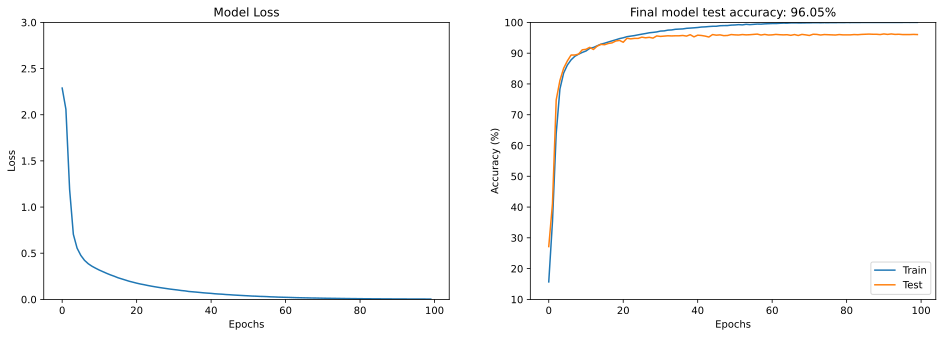

In [30]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model Loss')
ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

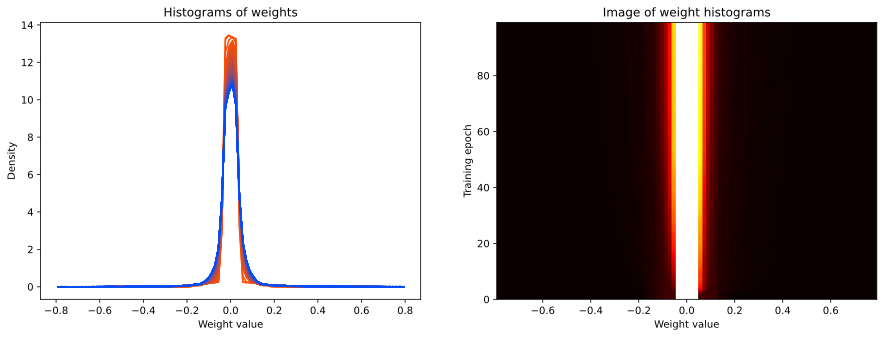

In [34]:
# show the histogram of the weights

fig,ax = plt.subplots(1,2,figsize=(15,5))

for i in range(counts.shape[0]):
  ax[0].plot(bin_centers,counts[i,:],color=[1-i/100,.3,i/100])

ax[0].set_title('Histograms of weights')
ax[0].set_xlabel('Weight value')
ax[0].set_ylabel('Density')


ax[1].imshow(counts,vmin=0,vmax=3,
             extent=[bin_centers[0],bin_centers[-1],0,99],aspect='auto',origin='lower',cmap='hot')
ax[1].set_xlabel('Weight value')
ax[1].set_ylabel('Training epoch')
ax[1].set_title('Image of weight histograms')

plt.show()